<div class="alert alert-info">

## 1. The Prediction Problem <a name="2"></a> 

In this mini project, we have a classification problem of predicting whether a credit card client will default or not. We use the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset), which contains 30,000 examples and 24 features. The goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled as "default.payment.next.month" in the data.  We rename this column to simply call it `default`. The values under this column are 0 for no default and 1 for default. The characteristics available to us to predict whether a person will default or not include their age, gender, education and payment history over the past few months. Based on intuition, the person's payment history should be extremely crucial in making predictions but we will assess if this is true by building different machine learning models and checking the importances of the features

### Imports

In [1]:
import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeCV, LinearRegression

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import shap
import eli5

C:\Users\robin\miniconda3\envs\573\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cc_df = pd.read_csv('data/UCI_Credit_Card.csv').rename(columns = {"default.payment.next.month":"default"})

# Some individuals with no bill amount (all BILL_AMT) are 0 but they're still being classified as defaulters. Drop these.
cc_df = cc_df[cc_df.loc[:,'BILL_AMT1':'BILL_AMT6'].sum(axis=1)!=0]
cc_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


<div class="alert alert-info">

## 2. Data splitting <a name="2"></a>

In [3]:
train_df, test_df = train_test_split(cc_df, test_size=0.20, random_state=123)

In [4]:
train_df.shape

(23304, 25)

In [5]:
test_df.shape

(5826, 25)

<div class="alert alert-info">

## 3. EDA <a name="3"></a>

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23304 entries, 23114 to 20565
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         23304 non-null  int64  
 1   LIMIT_BAL  23304 non-null  float64
 2   SEX        23304 non-null  int64  
 3   EDUCATION  23304 non-null  int64  
 4   MARRIAGE   23304 non-null  int64  
 5   AGE        23304 non-null  int64  
 6   PAY_0      23304 non-null  int64  
 7   PAY_2      23304 non-null  int64  
 8   PAY_3      23304 non-null  int64  
 9   PAY_4      23304 non-null  int64  
 10  PAY_5      23304 non-null  int64  
 11  PAY_6      23304 non-null  int64  
 12  BILL_AMT1  23304 non-null  float64
 13  BILL_AMT2  23304 non-null  float64
 14  BILL_AMT3  23304 non-null  float64
 15  BILL_AMT4  23304 non-null  float64
 16  BILL_AMT5  23304 non-null  float64
 17  BILL_AMT6  23304 non-null  float64
 18  PAY_AMT1   23304 non-null  float64
 19  PAY_AMT2   23304 non-null  float64
 20  PA

In [7]:
train_df.nunique()

ID           23304
LIMIT_BAL       80
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    18706
BILL_AMT2    18421
BILL_AMT3    18124
BILL_AMT4    17776
BILL_AMT5    17333
BILL_AMT6    17028
PAY_AMT1      6885
PAY_AMT2      6843
PAY_AMT3      6505
PAY_AMT4      6025
PAY_AMT5      5966
PAY_AMT6      5987
default          2
dtype: int64

There are 24 potential features and one target (binary, with 1 corresponding to positive defaults).

- Feature Descriptions:
    - `ID`: Unique identifier. Drop. 
    - `LIMIT_BAL`: Maximum credit. Numeric.
    - `SEX`: Binary/Numeric. Drop due to ethical reasons.
    - `EDUCATION`: Different education levels are treated as Ordinal sine there's an inherent order. 
    - `MARRIAGE`: No inherent order so not ordinal and hence, will be OHE (one hot encoded) as a categorical.
    - `AGE`: Numeric integer. 
    - `PAY_0` -> `PAY_6`: Ordinals represent payment behavior over time. In this series, "0" refers to the most recent month when data was collected, and each subsequent value represents a month before that. A low value like "-1" means timely payment, while positive values like "2" show a payment delay of 2 months. There are also values like "0" and "-2" whose exact meanings aren't clear. "0" might signify a partial repayment, and "-2" could mean overpayment or no credit usage. Though these values are rare, they're retained to preserve the sequence's order. Since they're already ordered numerically, it's fine to interpret them as standard numerics.
    - `BILL_AMT1` -> `BILL_AMT6`: Similar to PAY columns. Corresponds to the amount owed. Numeric. 
    - `PAY_AMT1` -> `PAY_AMT6`: Similar to PAY columns. Corresponds to amount paid. Numeric.

In [8]:
prop_neg = round(train_df['default'].value_counts()[0]/train_df.shape[0],2)
prop_pos = round(train_df['default'].value_counts()[1]/train_df.shape[0],2)

print (f"Proportion of positive class:{prop_pos}")
print (f"Proportion of negative class:{prop_neg}")

Proportion of positive class:0.22
Proportion of negative class:0.78


We have class imbalance since approximately 22% of the examples are defaulting while 78% are not defaulting. 

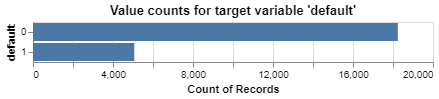

In [9]:
alt.Chart(train_df,title = "Value counts for target variable 'default'").mark_bar().encode(
    y = alt.Y("default:N"),
    x = alt.X("count()"))

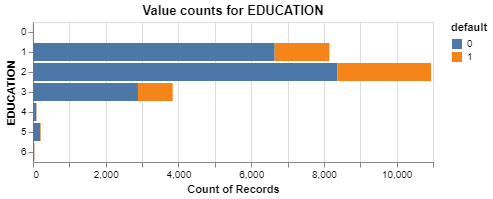

In [10]:
alt.Chart(train_df,title = "Value counts for EDUCATION").mark_bar().encode(
    y = alt.Y("EDUCATION:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

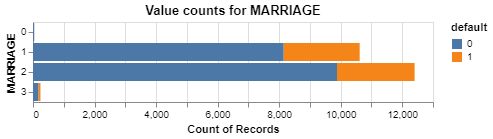

In [11]:
alt.Chart(train_df,title = "Value counts for MARRIAGE").mark_bar().encode(
    y = alt.Y("MARRIAGE:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

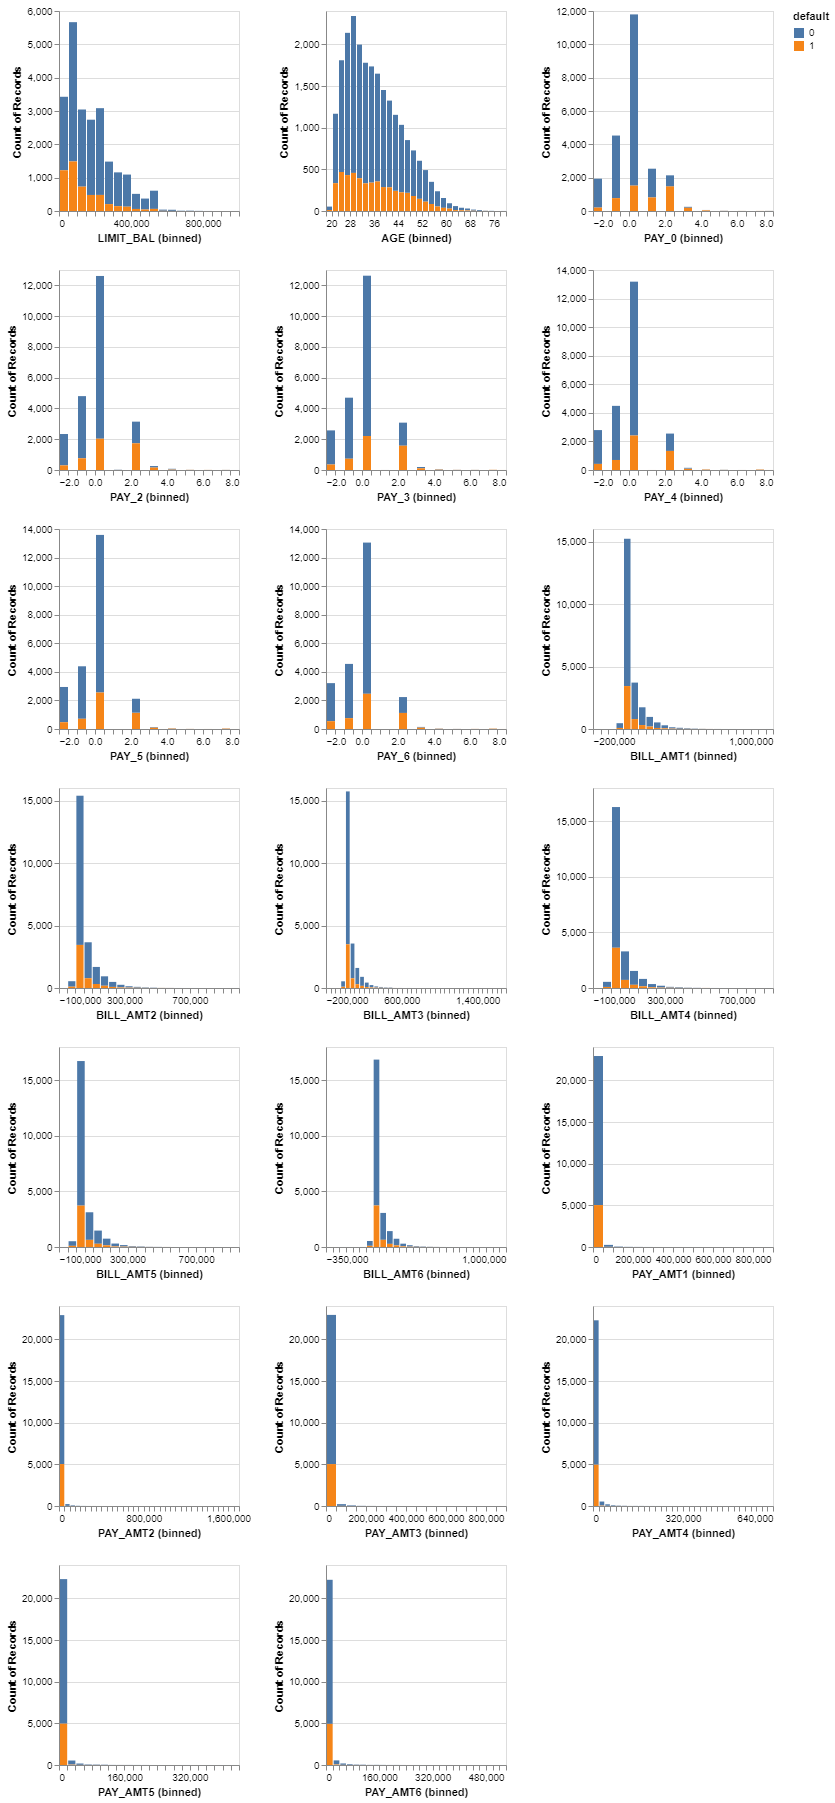

In [12]:
numeric_cols = train_df.select_dtypes(
    include=np.number).drop(
    columns=["ID", "SEX", "default", "MARRIAGE", "EDUCATION"]).columns.to_list()

alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
    color='default:N'
).properties(
    width=180,
    height=200
).repeat(
    numeric_cols, columns=3
)

In [13]:
train_df[numeric_cols].corr('kendall').style.background_gradient()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.131779,-0.237038,-0.268373,-0.258503,-0.240751,-0.219675,-0.205549,0.092536,0.087368,0.092922,0.096039,0.098858,0.102886,0.228964,0.231723,0.236109,0.233656,0.241166,0.256385
AGE,0.131779,1.000000,-0.050595,-0.060349,-0.060294,-0.058086,-0.059998,-0.056172,0.011452,0.012238,0.012562,0.008041,0.009296,0.008717,0.033434,0.041956,0.032843,0.036711,0.034340,0.035305
PAY_0,-0.237038,-0.050595,1.000000,0.651403,0.547391,0.515548,0.485602,0.456179,0.266036,0.268999,0.258192,0.251179,0.243244,0.235635,-0.077176,-0.045156,-0.041377,-0.026940,-0.020122,-0.034307
PAY_2,-0.268373,-0.060349,0.651403,1.000000,0.744246,0.643324,0.600948,0.556894,0.401564,0.388627,0.362467,0.345491,0.330518,0.317540,-0.044585,0.008570,0.010722,0.019331,0.023161,0.014554
PAY_3,-0.258503,-0.060294,0.547391,0.744246,1.000000,0.746045,0.647590,0.595340,0.361118,0.418469,0.397471,0.375386,0.356580,0.340381,0.121662,-0.032065,0.022285,0.040792,0.044929,0.029804
PAY_4,-0.240751,-0.058086,0.515548,0.643324,0.746045,1.000000,0.771896,0.662369,0.352158,0.393205,0.450043,0.432896,0.404379,0.383764,0.093141,0.148982,-0.009804,0.059728,0.076699,0.067910
PAY_5,-0.219675,-0.059998,0.485602,0.600948,0.647590,0.771896,1.000000,0.770312,0.346392,0.381283,0.426259,0.485475,0.462619,0.428011,0.085656,0.128916,0.160215,0.029647,0.097097,0.093750
PAY_6,-0.205549,-0.056172,0.456179,0.556894,0.595340,0.662369,0.770312,1.000000,0.334737,0.366422,0.400358,0.443267,0.501123,0.471536,0.085051,0.105313,0.139497,0.181310,0.054586,0.110936
BILL_AMT1,0.092536,0.011452,0.266036,0.401564,0.361118,0.352158,0.346392,0.334737,1.000000,0.806192,0.725998,0.656554,0.609968,0.571007,0.367968,0.337232,0.304537,0.305664,0.290182,0.282848
BILL_AMT2,0.087368,0.012238,0.268999,0.388627,0.418469,0.393205,0.381283,0.366422,0.806192,1.000000,0.799521,0.712527,0.652694,0.608829,0.486725,0.364077,0.331197,0.324764,0.313073,0.302004


There seems to be a high correlation between consecutive `PAY_` columns like `PAY_2` and `PAY_3` etc as well as between consecutive `BILL_AMT_` columns. If a person doesn't pay one month, it's likely they would do so again.

In [14]:
# recategorizing classses 0, 5, 6 in education as "Others" for train
train_df['EDUCATION'] = train_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for train
train_df['MARRIAGE'] = train_df['MARRIAGE'].replace(0, 3)

# recategorizing classses 0, 5, 6 in education as "Others" for test
test_df['EDUCATION'] = test_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for test                
test_df['MARRIAGE'] = test_df['MARRIAGE'].replace(0, 3)

<div class="alert alert-info">

## 4. Feature engineering

New features that are potentially relevant for the problem are created. Specifically, four new features have been created:
- Max of the `PAY` statuses:
   - This feature reflects the longest the individual has gone without paying a bill throughout their credit payment history as depicted in the dataset. A larger value would indicate an individual did not pay the bill for a long time. 'max' was chosen as it indicates the most severe continuous failure to pay. Summing this value was also tested (total payment behavior) but this was found to be a less powerful feature. When a customer consistently fails to pay their balance over several months, the values in this series of features will form a sequence. For instance, if a customer was 3 months late on their payment in one month (let's call it PAY_1), it would logically mean they were 2 months late in the previous month (PAY_0). This pattern would continue, revealing a predictable sequence if the customer continues not to pay.  
- Sum of `BILL_AMT_`
   - The total amount due for an individual.
- Sum of `PAY_AMT_`
   - The total amount paid by an individual.
- Average of payment ratio
   - We first calculate the payment ratio per month (e.g. PAY_AMT1/BILL_AMT2 due to time lag), and then take the average. This shows the individual's repayment ability. Full repayment equates to 1, no payment is 0, and partial payment ranges from 0-1. 
   - To deal with division by zero (i.e. `BILL_AMT_` is zero), we set the payment ratio of the month to 1.

In [15]:
# creating total_pay for train
train_df = train_df.assign(longest_unpaid_streak=train_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for train
train_df = train_df.assign(total_bill=train_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for train
train_df = train_df.assign(total_paid=train_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for train (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(train_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(train_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
train_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

# creating total_pay for test
test_df = test_df.assign(longest_unpaid_streak=test_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for test
test_df = test_df.assign(total_bill=test_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for test
test_df = test_df.assign(total_paid=test_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for test (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(test_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(test_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
test_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

In [16]:
# creating X_train, y_train, X_test and y_test
X_train = train_df.drop(columns='default')
y_train = train_df['default']
X_test = test_df.drop(columns='default')
y_test = test_df['default']

<div class="alert alert-info">

## 5. Preprocessing and transformations <a name="5"></a>

In [17]:
drop_features = ['ID', 'SEX']
numeric_features = ['LIMIT_BAL', 'AGE',
                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                    'longest_unpaid_streak', 'total_bill', 'total_paid', 'avg_pay_ratio']
ordinal_features = ['EDUCATION']
ordinal_levels = [1, 2, 3, 4]

categorical_features = ['MARRIAGE']

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(categories=[ordinal_levels]), ordinal_features),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features),
    ("drop", drop_features)   
)

<div class="alert alert-info">

## 6. Baseline model <a name="6"></a>

As a first step, a baseline model is trained using a `DummyClassifier` and its performance is reported. Dummy always predicts "no default," leading to a score of 0 for all metrics except accuracy, as there are neither True Positives nor False Positives recorded.

In [18]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

classification_metrics = ["accuracy", "precision", "recall", "f1"]
dc = DummyClassifier()
cross_val_results = {}
cross_val_results['dummy'] = (pd.DataFrame(cross_validate(dc,
                                                         X_train,
                                                         y_train,
                                                         return_train_score=True,
                                                         scoring=classification_metrics))
                              .agg(['mean', 'std']).round(3).T)

# Show the train and validation scores
cross_val_results['dummy']

,mean,std
fit_time,0.003,0.001
score_time,0.004,0.003
test_accuracy,0.783,0.000
train_accuracy,0.783,0.000
test_precision,0.000,0.000
train_precision,0.000,0.000
test_recall,0.000,0.000
train_recall,0.000,0.000
test_f1,0.000,0.000
train_f1,0.000,0.000


<div class="alert alert-info">

## 7. Logistic Regression <a name="7"></a>

Catching genuine defaults is our main purpose, so recall is very important (and hence the F1 score) in this scenario and we begin with using `LogisticRegression` along with hyperparameter optimization. We tune the `C` hyperparameter via `RandomizeSearchCV` (`class_weight` is set to be `balanced` to account for the class imbalance) which gives us a validation recall score of 65.4% and F1 score of 51.9%. It is very close to the training recall (65.3%) which means our model is not overfitting. Furthermore, our logistic regression model automatically deals with the class imbalance by choosing class_weight='balanced' during hyperparameter optimization.

In [19]:
from scipy.stats import lognorm, loguniform, randint

pipe_logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123,
                                                             max_iter=1000, 
                                                             class_weight = 'balanced'))

param_dist_logreg = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_dist_logreg,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring = 'f1'
)
random_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                                                                                             sparse=False),
                                                                               ['MARRIAGE']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['ID',
                                                                                'SEX'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000204E2F123E0>},
                   random_state=123, return_train_score=True, scoring='f1')

In [20]:
cross_val_results['logreg'] = pd.DataFrame(cross_validate(random_search_logreg.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg']

,mean,std
fit_time,0.049,0.004
score_time,0.003,0.004
test_accuracy,0.741,0.006
train_accuracy,0.742,0.002
test_precision,0.435,0.007
train_precision,0.437,0.003
test_recall,0.647,0.015
train_recall,0.648,0.001
test_f1,0.520,0.002
train_f1,0.522,0.003


In [21]:
random_search_logreg.best_params_

{'logisticregression__C': 0.003569682906906476}

<div class="alert alert-info">

## 8. Other models <a name="8"></a>

Now, we use three non-linear models and compare them to `LogisticRegression`. 
   - Naive Bayes
   - RandomForestClassifier
   - LGBM

Based on the results, Naive Bayes is outstanding in terms of recall score. The recall score for Naive Bayes is 86.5% (but precision is very low and hence the F1 is also very low, so this might not be the best model since it is very broad), followed by logistic regression (65.4%) and LGBM (61%). In addition, Naive Bayes does not overfit at all because of the comparable test score and validation score. On the other hand, overfitting is observed in Random Forest and LGBM. We will further improve our models using feature selection and hyperparameter optimization.

# (Gaussian) Naive Bayes

In [22]:
NB_bal = make_pipeline(preprocessor, GaussianNB())

cross_val_results['NB_bal'] = pd.DataFrame(cross_validate(NB_bal,
                                  X_train,
                                  y_train,
                                  return_train_score=True,
                                  scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB_bal']

,mean,std
fit_time,0.024,0.008
score_time,0.010,0.006
test_accuracy,0.434,0.032
train_accuracy,0.434,0.032
test_precision,0.260,0.009
train_precision,0.260,0.008
test_recall,0.865,0.022
train_recall,0.866,0.029
test_f1,0.399,0.008
train_f1,0.399,0.006


# Random Forest

In [23]:
RF_bal = make_pipeline(preprocessor,
                       RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_bal'] = pd.DataFrame(cross_validate(RF_bal,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_bal'] 

,mean,std
fit_time,3.317,0.026
score_time,0.075,0.004
test_accuracy,0.820,0.003
train_accuracy,1.000,0.000
test_precision,0.670,0.018
train_precision,1.000,0.000
test_recall,0.338,0.012
train_recall,1.000,0.000
test_f1,0.449,0.011
train_f1,1.000,0.000


# Light GBM

In [24]:
from lightgbm.sklearn import LGBMClassifier

LGBM_bal = make_pipeline(preprocessor,
                         LGBMClassifier(class_weight="balanced", n_estimators = 100, random_state=123))

cross_val_results['LGBM_bal'] = pd.DataFrame(cross_validate(LGBM_bal,
                                                            X_train,
                                                            y_train,
                                                            return_train_score=True,
                                                            scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['LGBM_bal']

,mean,std
fit_time,0.177,0.016
score_time,0.015,0.007
test_accuracy,0.768,0.006
train_accuracy,0.830,0.003
test_precision,0.474,0.009
train_precision,0.582,0.007
test_recall,0.610,0.018
train_recall,0.778,0.009
test_f1,0.533,0.005
train_f1,0.666,0.005


In [25]:
combined_results = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

combined_results

,dummy,logreg,NB_bal,RF_bal,LGBM_bal
fit_time,0.003,0.049,0.024,3.317,0.177
score_time,0.004,0.003,0.010,0.075,0.015
test_accuracy,0.783,0.741,0.434,0.820,0.768
train_accuracy,0.783,0.742,0.434,1.000,0.830
test_precision,0.000,0.435,0.260,0.670,0.474
train_precision,0.000,0.437,0.260,1.000,0.582
test_recall,0.000,0.647,0.865,0.338,0.610
train_recall,0.000,0.648,0.866,1.000,0.778
test_f1,0.000,0.520,0.399,0.449,0.533
train_f1,0.000,0.522,0.399,1.000,0.666


<div class="alert alert-info">

## 9. Feature selection

We'll employ Feature Selection to select the relevant features (and hence shrink/remove the irrelevant features). We use `RFECV` to reduce the feature space, using `RidgeClassifier` to generate feature importance since it is robust to multicolinearity. We start with 28 features and using `RidgeClassifier` to reduce the feature space leaves us with the 5 most important features.

Key findings: 
* Using feature selection leads to
    * better validation score for random forest;
        * Reducing the number of features does slightly reduce overfitting, we will keep the feature selection in the pipeline for random forest.
    * marginally worse validation score for logistic regression and LGBM;
        * The reduction in the scores is extremely small. By removing 23 features, we are significantly reducing the complexity of our model. So for both models we will keep the RFECV step, using only the subset of 5 features in our model.
    * significantly worse validation score for Naive Bayes;
        * Since no improvement is observed, we will abandon the feature selection in the pipeline for Naive Bayes

# Logistic Regression

In [26]:
pipe_logreg.fit(X_train, y_train) 
pipe_logreg.named_steps["logisticregression"].n_features_in_

28

In [27]:
logreg_RFE = make_pipeline(preprocessor,
                           RFECV(RidgeClassifier(), cv=10),
                           LogisticRegression(class_weight="balanced",
                                              random_state=123,
                                              max_iter=1000))

param_dist = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg_RFE = RandomizedSearchCV(
    logreg_RFE,
    param_distributions=param_dist,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)
random_search_logreg_RFE.fit(X_train, y_train)

cross_val_results['logreg_RFE'] = pd.DataFrame(cross_validate(random_search_logreg_RFE.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [28]:
df = pd.concat([cross_val_results['logreg'], cross_val_results['logreg_RFE']], axis=1)
df.columns=['logreg mean', 'logreg std', 'logreg_RFE mean', 'logreg_RFE std']
df

,logreg mean,logreg std,logreg_RFE mean,logreg_RFE std
fit_time,0.049,0.004,2.116,0.049
score_time,0.003,0.004,0.008,0.000
test_accuracy,0.741,0.006,0.742,0.003
train_accuracy,0.742,0.002,0.742,0.002
test_precision,0.435,0.007,0.437,0.003
train_precision,0.437,0.003,0.436,0.002
test_recall,0.647,0.015,0.638,0.014
train_recall,0.648,0.001,0.638,0.003
test_f1,0.520,0.002,0.518,0.004
train_f1,0.522,0.003,0.518,0.002


In [29]:
logreg_RFE.fit(X_train, y_train)
logreg_RFE.named_steps["logisticregression"].n_features_in_

5

### Selected features (also see SHAP later on)

In [30]:
mask = logreg_RFE.named_steps["rfecv"].support_
feature_names = numeric_features + ordinal_features + ['Marriage1', 'Marriage2', 'Marriage3']
selected_feats = np.array(feature_names)
selected_feats[mask]

array(['PAY_0', 'PAY_2', 'BILL_AMT1', 'longest_unpaid_streak',
       'Marriage1'], dtype='<U21')

# Naive Bayes

In [31]:
NB_bal_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), GaussianNB())

cross_val_results['NB_bal_RFE'] = pd.DataFrame(cross_validate(NB_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

In [32]:
df = pd.concat([cross_val_results['NB_bal'], cross_val_results['NB_bal_RFE']], axis=1)
df.columns=['NB_bal mean', 'NB_bal std', 'NB_bal_RFE mean', 'NB_bal_RFE std']
df

,NB_bal mean,NB_bal std,NB_bal_RFE mean,NB_bal_RFE std
fit_time,0.024,0.008,2.113,0.060
score_time,0.010,0.006,0.007,0.001
test_accuracy,0.434,0.032,0.809,0.005
train_accuracy,0.434,0.032,0.809,0.003
test_precision,0.260,0.009,0.569,0.015
train_precision,0.260,0.008,0.570,0.010
test_recall,0.865,0.022,0.500,0.022
train_recall,0.866,0.029,0.501,0.004
test_f1,0.399,0.008,0.532,0.013
train_f1,0.399,0.006,0.533,0.003


In [33]:
NB_bal_RFE.fit(X_train,y_train)
NB_bal_RFE.named_steps['gaussiannb'].n_features_in_

5

# Random Forest

In [34]:
RF_bal_RFE = make_pipeline(preprocessor,
                           RFECV(RidgeClassifier(), cv=10),
                           RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_bal_RFE'] = pd.DataFrame(cross_validate(RF_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

In [35]:
df = pd.concat([cross_val_results['RF_bal'], cross_val_results['RF_bal_RFE']], axis=1)
df.columns=['RF_bal mean', 'RF_bal std', 'RF_bal_RFE mean', 'RF_bal_RFE std']
df

,RF_bal mean,RF_bal std,RF_bal_RFE mean,RF_bal_RFE std
fit_time,3.317,0.026,3.522,0.253
score_time,0.075,0.004,0.087,0.010
test_accuracy,0.820,0.003,0.769,0.049
train_accuracy,1.000,0.000,0.987,0.011
test_precision,0.670,0.018,0.499,0.154
train_precision,1.000,0.000,0.965,0.032
test_recall,0.338,0.012,0.381,0.021
train_recall,1.000,0.000,0.978,0.020
test_f1,0.449,0.011,0.422,0.046
train_f1,1.000,0.000,0.971,0.026


In [36]:
RF_bal_RFE.fit(X_train,y_train)
RF_bal_RFE.named_steps['randomforestclassifier'].n_features_in_

5

# LGBM

In [37]:
LGBM_bal_RFE = make_pipeline(preprocessor,
                             RFECV(RidgeClassifier(), cv=10),
                             LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_bal_RFE'] = pd.DataFrame(cross_validate(LGBM_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

In [38]:
df = pd.concat([cross_val_results['LGBM_bal'], cross_val_results['LGBM_bal_RFE']], axis=1)
df.columns=['LGBM_bal mean', 'LGBM_bal std', 'LGBM_bal_RFE mean', 'LGBM_bal_RFE std']
df

,LGBM_bal mean,LGBM_bal std,LGBM_bal_RFE mean,LGBM_bal_RFE std
fit_time,0.177,0.016,2.271,0.077
score_time,0.015,0.007,0.020,0.008
test_accuracy,0.768,0.006,0.765,0.009
train_accuracy,0.830,0.003,0.792,0.011
test_precision,0.474,0.009,0.469,0.015
train_precision,0.582,0.007,0.516,0.019
test_recall,0.610,0.018,0.603,0.022
train_recall,0.778,0.009,0.675,0.060
test_f1,0.533,0.005,0.527,0.002
train_f1,0.666,0.005,0.584,0.034


In [39]:
LGBM_bal_RFE.fit(X_train,y_train)
LGBM_bal_RFE.named_steps['lgbmclassifier'].n_features_in_

5

In [40]:
combined_results_fs = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
   precision=3
)

combined_results_fs
col_list = combined_results_fs.columns.tolist()
col_list.sort()
col_list
combined_results_fs = combined_results_fs.data
combined_results_fs[col_list]

,LGBM_bal,LGBM_bal_RFE,NB_bal,NB_bal_RFE,RF_bal,RF_bal_RFE,dummy,logreg,logreg_RFE
fit_time,0.177,2.271,0.024,2.113,3.317,3.522,0.003,0.049,2.116
score_time,0.015,0.020,0.010,0.007,0.075,0.087,0.004,0.003,0.008
test_accuracy,0.768,0.765,0.434,0.809,0.820,0.769,0.783,0.741,0.742
train_accuracy,0.830,0.792,0.434,0.809,1.000,0.987,0.783,0.742,0.742
test_precision,0.474,0.469,0.260,0.569,0.670,0.499,0.000,0.435,0.437
train_precision,0.582,0.516,0.260,0.570,1.000,0.965,0.000,0.437,0.436
test_recall,0.610,0.603,0.865,0.500,0.338,0.381,0.000,0.647,0.638
train_recall,0.778,0.675,0.866,0.501,1.000,0.978,0.000,0.648,0.638
test_f1,0.533,0.527,0.399,0.532,0.449,0.422,0.000,0.520,0.518
train_f1,0.666,0.584,0.399,0.533,1.000,0.971,0.000,0.522,0.518


Summary of the results are as follows: 
- Logistic Regression:
    - Feature selection results in a very slight reduction in the F1 score and a significant increase in fitting time.

- Naive Bayes:
    - Struggles with irrelevant features due to its inability to manage feature importances.
    - Introducing feature selection elevates the model's performance; although recall drops, there's a notable increase in precision and a substantial boost in the F1 score. 

- Random Forests:
    - Due to the computational demands of Random Forests, feature selection can reduce the model's fitting time.
    - If we enhance the computational budget (adjusting the n_estimators hyperparameter), the time saved might be more pronounced. This is because while RFECV duration remains constant, the time per tree decreases.
    - However, the F1 score declines considerably after feature selection. 

- LightGBM:
    - Feature selection leads to a minor F1 score reduction and a considerable fitting time increase, mirroring the Logistic Regression scenario.
    - Even though reducing the time to fit each tree might theoretically outweigh the time consumed by feature selection, our current setting of 100 estimators doesn't support this trade-off.
    - While a 5-feature model is more interpretable than a 28-feature model, understanding even a 5-feature gradient-boosted tree remains challenging. We will employ tools like eli5 and SHAP for interpretation.

<div class="alert alert-info">

## 10. Non-Linear model Hyperparameter optimization

As seen above, we have

- Logisitic Regression: `logreg_RFE`, which is Logistic Regression with optimized hyperparameters and with feature selection. It gives us a validation score of 64.2%. The hyperparameters,`class_weight` and `C`, were optimized.

We perform hyperparamater optimization on all the non-linear models that we built above.

# Naive Bayes

In [41]:
param_dist_nb = {
    "gaussiannb__var_smoothing": np.logspace(0, -9, num=100)
}

random_search_NB = RandomizedSearchCV(
    NB_bal_RFE,
    param_distributions=param_dist_nb,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)

In [42]:
random_search_NB.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=123, return_train_score=True, scoring='f1')

In [43]:
random_search_NB.best_params_

{'gaussiannb__var_smoothing': 0.0533669923120631}

In [44]:
cross_val_results['NB_opt'] = pd.DataFrame(
    cross_validate(random_search_NB.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB_opt'] 

,mean,std
fit_time,2.212,0.045
score_time,0.007,0.001
test_accuracy,0.811,0.004
train_accuracy,0.811,0.002
test_precision,0.575,0.012
train_precision,0.574,0.006
test_recall,0.499,0.021
train_recall,0.498,0.004
test_f1,0.534,0.014
train_f1,0.533,0.004


# Random Forest

In [45]:
param_dist_rf = {
    "randomforestclassifier__max_depth": randint(0, 20),
    "randomforestclassifier__max_features": randint(1, 30)
}

random_search_RF = RandomizedSearchCV(
    RF_bal,
    param_distributions=param_dist_rf,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)

In [46]:
random_search_RF.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                                                                     random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000204E3E2B8E0>,
                                        'randomforestclassifier__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000204E3871B70>},
                   random_state=123, return_train_score=True, scoring='f1')

In [47]:
random_search_RF.best_params_

{'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 3}

In [48]:
cross_val_results['RF_opt'] = pd.DataFrame(
    cross_validate(random_search_RF.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics,
                  n_jobs=-1)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_opt'] 

,mean,std
fit_time,1.966,0.009
score_time,0.056,0.004
test_accuracy,0.799,0.004
train_accuracy,0.857,0.002
test_precision,0.536,0.011
train_precision,0.662,0.004
test_recall,0.548,0.014
train_recall,0.698,0.003
test_f1,0.542,0.006
train_f1,0.680,0.003


# LGBM

In [49]:
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore')

param_dist_lgbm = {
    "lgbmclassifier__learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    "lgbmclassifier__max_depth": randint(0, 20),
    "lgbmclassifier__num_leaves": [2, 3, 5, 10, 25, 50, 100],
}

random_search_LGBM = RandomizedSearchCV(
    LGBM_bal,
    param_distributions=param_dist_lgbm,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='recall'
)

In [50]:
random_search_LGBM.fit(X_train, y_train);

In [51]:
random_search_LGBM.best_params_

{'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': 3,
 'lgbmclassifier__num_leaves': 25}

In [52]:
cross_val_results['LGBM_opt'] = pd.DataFrame(
    cross_validate(random_search_LGBM.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['LGBM_opt'] 

,mean,std
fit_time,0.119,0.009
score_time,0.019,0.002
test_accuracy,0.758,0.005
train_accuracy,0.770,0.004
test_precision,0.460,0.007
train_precision,0.479,0.006
test_recall,0.637,0.017
train_recall,0.668,0.003
test_f1,0.534,0.005
train_f1,0.558,0.004


### Hyperparam Tuning Results

In [53]:
combined_results_opt = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
col_list_opt
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM_bal,LGBM_bal_RFE,LGBM_opt,NB_bal,NB_bal_RFE,NB_opt,RF_bal,RF_bal_RFE,RF_opt,dummy,logreg,logreg_RFE
fit_time,0.177,2.271,0.119,0.024,2.113,2.212,3.317,3.522,1.966,0.003,0.049,2.116
score_time,0.015,0.020,0.019,0.010,0.007,0.007,0.075,0.087,0.056,0.004,0.003,0.008
test_accuracy,0.768,0.765,0.758,0.434,0.809,0.811,0.820,0.769,0.799,0.783,0.741,0.742
train_accuracy,0.830,0.792,0.770,0.434,0.809,0.811,1.000,0.987,0.857,0.783,0.742,0.742
test_precision,0.474,0.469,0.460,0.260,0.569,0.575,0.670,0.499,0.536,0.000,0.435,0.437
train_precision,0.582,0.516,0.479,0.260,0.570,0.574,1.000,0.965,0.662,0.000,0.437,0.436
test_recall,0.610,0.603,0.637,0.865,0.500,0.499,0.338,0.381,0.548,0.000,0.647,0.638
train_recall,0.778,0.675,0.668,0.866,0.501,0.498,1.000,0.978,0.698,0.000,0.648,0.638
test_f1,0.533,0.527,0.534,0.399,0.532,0.534,0.449,0.422,0.542,0.000,0.520,0.518
train_f1,0.666,0.584,0.558,0.399,0.533,0.533,1.000,0.971,0.680,0.000,0.522,0.518


The best recall scores are provided by LGBM and Logistic Regression (0.628 and 0.6654 respectively). Naive Bayes has the lowest recall (0.499), but because of its higher precision still has a relatively strong F1 score. Through hyperparameter tuning, we achieved an enhancement in the F1 score across almost all models. All models demonstrated comparable performance levels after tuning, with F1 scores on the test data being greater than 0.5. It's noteworthy that there's potential to further refine the scores for both Random Forest and LGBM by adjusting the `n_estimators` hyperparameter upwards. However, such an adjustment hinges on the available computational resources. Should we deploy this model in an environment with ample computing power, it would be worth exploring higher values for `n_estimators`, as they could theoretically yield superior outcomes.

### Ensemble Model

A voting classifier is a machine learning model that takes the outputs of several other models and makes a final prediction based on their individual predictions. 
    
- Hard Voting: Here, every individual model in the ensemble "votes" for a class, and the class that gets the most votes is chosen as the final prediction.
- Soft Voting: In soft voting, instead of voting for a single class, each model predicts the probabilities for each class. The final class prediction is then based on the averaged probabilities.
    
We choose to opt for soft voting because it considers the "model confidence," which means it factors in how sure each model is about its prediction. In essence, soft voting allows the ensemble to make decisions that are not just based on the majority rule but also on how confident each model is about its prediction. This often leads to more nuanced and potentially more accurate predictions which is why we use it below. 

In [54]:
final_classifiers =  {
    "logistic regression": random_search_logreg,
    "random forest": random_search_RF,
    "LightGBM": random_search_LGBM,
    "Naive Bayes": random_search_NB
}

In [55]:
averaged_model = VotingClassifier(
    list(final_classifiers.items()), voting='soft')

In [56]:
cross_val_results['averaged'] = pd.DataFrame(
    cross_validate(averaged_model,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

cross_val_results['averaged'];

In [57]:
combined_results_opt = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
col_list_opt
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM_bal,LGBM_bal_RFE,LGBM_opt,NB_bal,NB_bal_RFE,NB_opt,RF_bal,RF_bal_RFE,RF_opt,averaged,dummy,logreg,logreg_RFE
fit_time,0.177,2.271,0.119,0.024,2.113,2.212,3.317,3.522,1.966,277.620,0.003,0.049,2.116
score_time,0.015,0.020,0.019,0.010,0.007,0.007,0.075,0.087,0.056,0.058,0.004,0.003,0.008
test_accuracy,0.768,0.765,0.758,0.434,0.809,0.811,0.820,0.769,0.799,0.802,0.783,0.741,0.742
train_accuracy,0.830,0.792,0.770,0.434,0.809,0.811,1.000,0.987,0.857,0.810,0.783,0.742,0.742
test_precision,0.474,0.469,0.460,0.260,0.569,0.575,0.670,0.499,0.536,0.546,0.000,0.435,0.437
train_precision,0.582,0.516,0.479,0.260,0.570,0.574,1.000,0.965,0.662,0.564,0.000,0.437,0.436
test_recall,0.610,0.603,0.637,0.865,0.500,0.499,0.338,0.381,0.548,0.544,0.000,0.647,0.638
train_recall,0.778,0.675,0.668,0.866,0.501,0.498,1.000,0.978,0.698,0.560,0.000,0.648,0.638
test_f1,0.533,0.527,0.534,0.399,0.532,0.534,0.449,0.422,0.542,0.544,0.000,0.520,0.518
train_f1,0.666,0.584,0.558,0.399,0.533,0.533,1.000,0.971,0.680,0.561,0.000,0.522,0.518


In [58]:
averaged_model.fit(X_train,y_train);

Text(0.5, 1.0, 'Precision-Recall Curves')

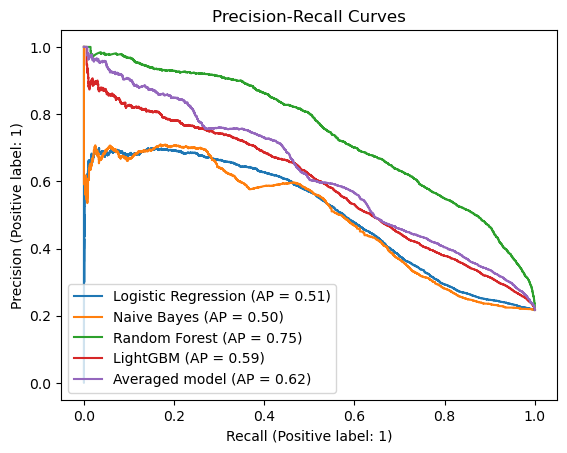

In [59]:
# the best estimators for each model are used below.
PrecisionRecallDisplay.from_estimator(random_search_logreg, X_train, y_train, ax = plt.gca(), name = "Logistic Regression")
PrecisionRecallDisplay.from_estimator(random_search_NB, X_train, y_train, ax = plt.gca(), name = "Naive Bayes")
PrecisionRecallDisplay.from_estimator(random_search_RF, X_train, y_train, ax = plt.gca(), name = "Random Forest")
PrecisionRecallDisplay.from_estimator(random_search_LGBM, X_train, y_train, ax = plt.gca(), name = "LightGBM")
PrecisionRecallDisplay.from_estimator(averaged_model, X_train, y_train, ax = plt.gca(), name = "Averaged model")
plt.title('Precision-Recall Curves')

Text(0.5, 1.0, 'ROC Curves')

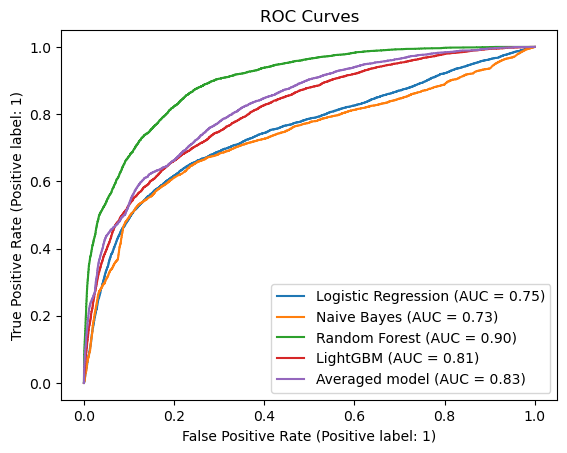

In [60]:
RocCurveDisplay.from_estimator(random_search_logreg.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Logistic Regression")
RocCurveDisplay.from_estimator(random_search_NB.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Naive Bayes")
RocCurveDisplay.from_estimator(random_search_RF.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Random Forest")
RocCurveDisplay.from_estimator(random_search_LGBM.best_estimator_, X_train, y_train, ax = plt.gca(), name = "LightGBM")
RocCurveDisplay.from_estimator(averaged_model, X_train, y_train, ax = plt.gca(), name = "Averaged model")

plt.title('ROC Curves')

## Model Selection

The F1 scores are comparable for majority of the models as discussed before. The PR-Curves and ROC Curves, however, allow us to distinguish the best model, which in this case is the Random Forest. At the baseline threshold of 0.5 `predict_proba`, it has the highest F1 score as well as the best AP and AUC scores. This shows that it is the most robust model in this scenario. We could choose our own operating point as is done below, but to choose the correct value requires in-depth industry knowledge. For example, at a precision of 0.5, the recall is approximately 0.9 which means that we we can catch 9 out of 10 defaults, a very healthy performance. 

The confusion matrix for the Random Forest model on the training set is shown as well. Our main concern lies in the lower-left quadrant, which represents false negatives. These are cases where the model predicted 'no default' when there was actually a default. To address this (in other words, to reduce the false negatives), we can modify the prediction probability threshold. By fine-tuning this threshold, we can achieve a desired balance between precision and recall as is shown in the second confusion matrix. 

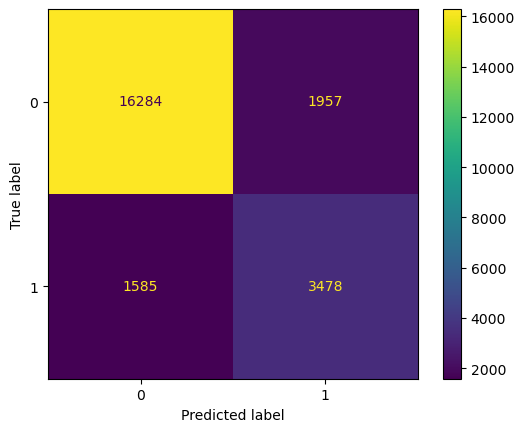

In [79]:
# baseline at predict proba = 0.5

ConfusionMatrixDisplay.from_estimator(random_search_RF.best_estimator_, X_train, y_train)

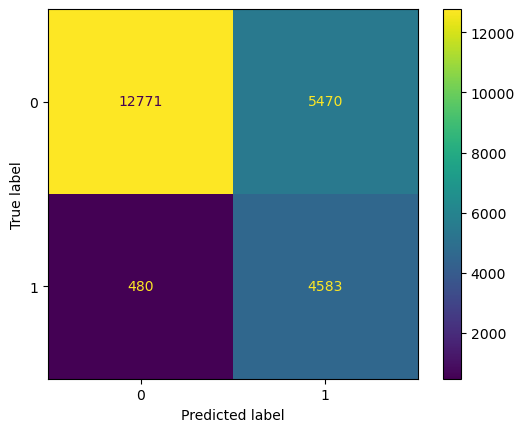

In [80]:
# 0.35 threshold

threshold = 0.35
y_pred = (random_search_RF.best_estimator_.predict_proba(X_train)[:, 1] > threshold).astype('float')
matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [82]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_train, random_search_RF.predict(X_train)
    )
)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     18241
           1       0.64      0.69      0.66      5063

    accuracy                           0.85     23304
   macro avg       0.78      0.79      0.78     23304
weighted avg       0.85      0.85      0.85     23304



Although reducing the threshold led to a decrease in false negatives, note that the overall error has increased (sum of diagonal is larger). However, most of these are false positives, and since our main focus is minimizing the false negatives, this trade-off could be worth it. 

The second best model appears to be the averaged model, and it's corresponding confusion matrix is also shown below. Although similar to the RF model, it is clear that RF is performing better. 

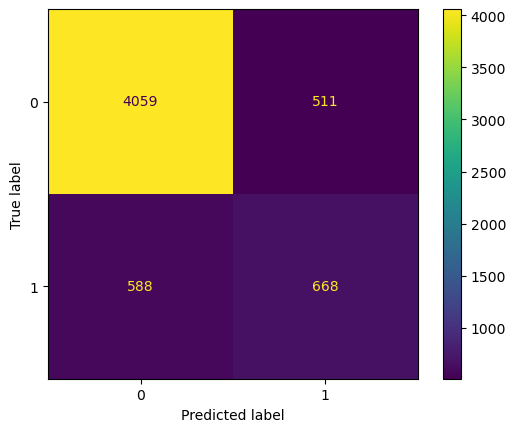

In [67]:
ConfusionMatrixDisplay.from_estimator(averaged_model, X_test, y_test )

In [71]:
print(
    classification_report(
        y_train, averaged_model.predict(X_train)
    )
)

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     18241
           1       0.59      0.56      0.58      5063

    accuracy                           0.82     23304
   macro avg       0.73      0.73      0.73     23304
weighted avg       0.82      0.82      0.82     23304



<div class="alert alert-info">

## 11. Interpretation and feature importances <a name="1"></a>

As an exercise, the most important features of the RF model are examined. 

## eli5

In [83]:
eli5.explain_weights(random_search_RF.best_estimator_.named_steps["randomforestclassifier"], feature_names=feature_names)

Weight,Feature
0.1535 ± 0.2577,PAY_0
0.1223 ± 0.2506,longest_unpaid_streak
0.0679 ± 0.1822,PAY_2
0.0467 ± 0.1324,PAY_4
0.0409 ± 0.0495,LIMIT_BAL
0.0395 ± 0.0437,avg_pay_ratio
0.0391 ± 0.0489,total_paid
0.0375 ± 0.1267,PAY_3
0.0348 ± 0.0375,PAY_AMT1
0.0332 ± 0.0227,BILL_AMT1


Why are the uncertainties so large? Explore this further (look into Gini index).

## Permutation importances

Permutation Importances evaluate feature importances by permuting/shuffling the values of a given feature across all examples, one feature at a time. If the feature plays a vital role in prediction, then its permutation should lead to a substantial increase in model error, indicating its importance. Conversely, if the error remains relatively stable, the feature is deemed less crucial. 

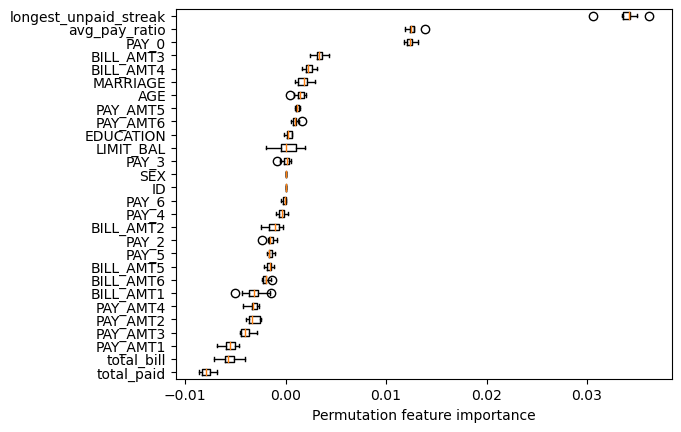

In [84]:
perm_imp = permutation_importance(random_search_LGBM.best_estimator_, X_train, y_train, n_repeats=10, random_state=123)
perm_imp_sorted = perm_imp.importances_mean.argsort()
plt.boxplot(
    perm_imp.importances[perm_imp_sorted].T,
    vert=False,
    labels=X_train.columns[perm_imp_sorted])
plt.xlabel('Permutation feature importance')
plt.show()

Similar to eli5, it appears that `longest_unpaid_streak`, `avg_pay_ratio`, `PAY_0`, etc. are some of the most important features. The error bars of these three features, specifically, do not overlap with majority of the others. This shows confident predictions via this method due to the significant separation between these features. 

## SHAP

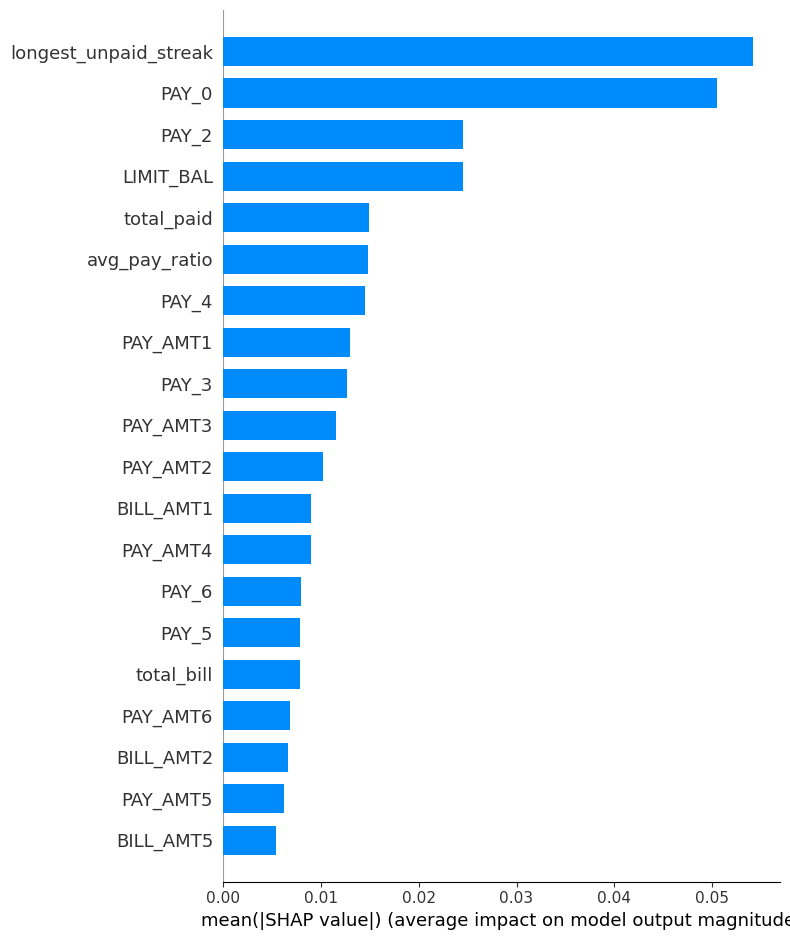

In [86]:
X_train_transformed = pd.DataFrame(data=preprocessor.transform(X_train),
                                   columns=feature_names,
                                   index=X_train.index)

rf_shap = shap.TreeExplainer(random_search_RF.best_estimator_.named_steps["randomforestclassifier"])
training_shap = rf_shap.shap_values(X_train_transformed)

shap.summary_plot(training_shap[1], X_train_transformed, plot_type = 'bar')

It appears that SHAP values agree with the eli5 values, especially the first 6 features. Note that these features are also present in the permutation importances features. Based on `eli5`, `permutation importance`, and `SHAP` we can see that `PAY_0` and `longest_unpaid_streak` are extremely significant. This makes reasonable sense, as an individual starting the payment period already having an unpaid balance (`PAY_0`) is likely to continue to not pay and eventually default, and individuals with longer extended streaks of not paying (`longest_unpaid_streak`) are more likely to eventually default. 

<div class="alert alert-info">

## 12. Results on the test set <a name="12"></a>

We now test our chosen model on the test data and examine the results. The recall score on our test dataset is 65.8% which is slightly lower than our train and validation scores. This is reasonable and makes sense. So our model is performing well. We do not have optimization bias because our dataset is large enough and we used pipeline to perform cross-validation. Also, we do not observe acute overfitting from the scores.

We will take one default=0 and one default=1 predictions and perform SHAP force plots.

default=0:
- This individual has a negative longest_unpaid_streak which is a sign of a good repayment record. (factor pushing to default=0)
- He/she has very low PAY_0 and PAY_2. That means there is no repayment issue with in recent months. (factor pushing to default=0)
- He/she is married. This is a slightly negative factor according to our model but this (factor pushing to default=1), but this is small in comparison to payment habits above.
- Summing up all the factors, the prediction for this individual is no default which matches the actual label.

default=1:
- This individual has a relatively large longest_unpaid_streak which is a negative sign. (factor pushing to default=1)
- He/she has a quite high PAY_0. (factor pushing to default=1)
- These two factors are already strong enough to predict this individual will default, which matches the actual label.

In [ ]:
from sklearn.metrics import recall_score

recall_score(y_test, averaged_model.predict(X_test))

In [ ]:
lgbm_explainer = shap.TreeExplainer(random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"])
X_test_transformed = pd.DataFrame(data = preprocessor.transform(X_test)[:,indices], 
                                   columns = feature_names, 
                                   index=X_test.index)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_transformed)

In [ ]:
y_test_reset = y_test.reset_index(drop=True)

defaultN_ind = y_test_reset[y_test_reset == 0].index.tolist()
defaultY_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_defaultN_index = defaultN_ind[9]
ex_defaultY_index = defaultY_ind[10]

In [ ]:
X_test_transformed.iloc[ex_defaultN_index]

In [ ]:
# hard prediction
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict(X_test_transformed)[ex_defaultN_index]

In [ ]:
# predict_proba
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_defaultN_index]

In [ ]:
shap.force_plot(
    lgbm_explainer.expected_value[1], # expected value for class 1. 
    test_lgbm_shap_values[1][ex_defaultN_index, :], # SHAP values associated with the example we want to explain
    X_test_transformed.iloc[ex_defaultN_index, :], # Feature vector of the example 
    matplotlib=True,
)

In [ ]:
X_test_transformed.iloc[ex_defaultY_index]

In [ ]:
# hard prediction
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict(X_test_transformed)[ex_defaultY_index]

In [ ]:
# predict_proba
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_defaultY_index]

In [ ]:
shap.force_plot(
    lgbm_explainer.expected_value[1], # expected value for class 1. 
    test_lgbm_shap_values[1][ex_defaultY_index, :], # SHAP values associated with the example we want to explain
    X_test_transformed.iloc[ex_defaultY_index, :], # Feature vector of the example 
    matplotlib=True,
)

<div class="alert alert-info">

## 13. Summary of results <a name="13"></a>

The goal of this project is to correctly predict if a credit card customer is going to default in the coming month. Since catching defaults is the first priority, recall is used as the scoring metric throughout our analysis. Recall is defined as the percentage of actual defaults that are be predicted correctly by our model.

We made use of the Default of Credit Card Clients Dataset in which there is information such as
- Limit balance
- Education level
- Marriage status
- Repayment status
- Amount billed
- Amount paid
- Our target 'whether default payment happened next month'.

We performed feature engineering to create new features based on the base features. The newly created features are:
- Longest unpaid streak
- Total bill amount
- Total paid amount
- Average payment ratio<br>

**Longest unpaid streak ended up being the most important factor for prediction, meaning our feature engineering was very successful.**

The data is split into two parts randomly: train set and test set. The train set was used to train our prediction model while the test set was left untouched until the end of model tuning to evaluate our model.

In order to achieve the goal, we have used different classification models:
- Logistic Regression
- (Gaussian) Naive Bayes
- Random Forest
- LightGBM

Since each model has its own pros and cons, we used feature selection and hyperparameter optimization to generate the optimal version of each model. In order to benefit from diversification, we applied a vote classifier that took the average of 4 best models. The cross validation recall score from our train set was 71.3%, with significantly higher precision than our original NB model. We opted to select the voting model because, despite a lower recall metric, the model did have far more robust `AP` and `f1` scores. While these are not our primary metric, they are still significant. Cross validation scores are shown in the table below.

We applied our diversified averaged model to the test set for a final evaluation. The score is 65.8% which is slightly less than the score from the train set.

The breakdown of true positives, true negatives, false positives and false negatives in the test set are shown in the Confusion Matrix below (Note: label 1 means default).

Although our recall score is pretty good, it is worth noting that there are a number of false positives as well (i.e. low precision). From the Precision-Recall curve, we can see the trade-off between precision and recall. We can strike the balance by choosing an appropriate operating point later after thorough discussion.

Among the features available in the data file, our training process identified 5 features which are the most important to our prediction. They are shown in the SHAP plot. Among them `longest_unpaid_streak` and `PAY_0` are the most important features meaning they have the biggest influence in the model. Both of them are important indicators about a bad client based on the recent repayment record.

Some ideas that may further improve our models:
- More feature engineering such as "number of months with repayment issues"
- More classification models such as SVC
- Other feature selection techniques such as forward / backward selection
- More extensive hyperparameter optimization with wider parameter distribution / grid
- Choosing an appropriate operating point

In [ ]:
final = ['logreg_RFE', 'LGBM_opt', 'NB_opt', 'RF_opt', 'averaged']
df = pd.DataFrame(combined_results_opt.loc['test_recall', final])
df.columns = ['Recall Score (CV on train set)']
df.index = ['Logistic Regression', 'LightGBM', 'Naive Bayes', 'Random Forest', 'AVERAGED MODEL']
df

In [ ]:
ConfusionMatrixDisplay.from_estimator(averaged_model, X_test, y_test )

In [ ]:
PrecisionRecallDisplay.from_estimator(averaged_model, X_test, y_test,name = "Averaged model")

In [ ]:
shap.summary_plot(training_shap[1], X_train_transformed, plot_type = 'bar')